In [19]:
####Dependencies
import ee
import geemap
import pandas as pd
import numpy as np
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,LogNorm
import os
import rasterio
from shapely.geometry import box
import matplotlib.patches as patches

## Inputs

#### Precipitation

In [ ]:
# Input and Output File Paths
file_path = "./Input_Data/Meteo/Otta_Daily_Precip_per_cell.csv"
output_file = "./Input_Data/Meteo/annual_precip_per_cell.csv"
total_precip_file = "./Input_Data/Meteo/total_annual_precip.csv"

# Grid configuration
xmin, ymin, xmax, ymax = 95000, 6837000, 213000, 6917000
cell_size = 1000  # 1 km x 1 km
cell_area = 1000000  # Area of each cell in square meters
n_cells_x = int((xmax - xmin) / cell_size)  # Number of cells along x-axis
n_total_cells = n_cells_x * n_cells_y  # Total number of cells (1 to 9440)

# Load the dataset
rainfall_data = pd.read_csv(file_path)

# Extract rainfall columns
rainfall_columns = [col for col in rainfall_data.columns if col.startswith("X")]
rainfall_data = rainfall_data[["x", "y"] + rainfall_columns]

# Convert the rainfall columns to datetime for filtering
rainfall_data.columns = ["x", "y"] + [
    pd.to_datetime(col[1:], format="%Y.%m.%d.%H.%M.%S") for col in rainfall_columns
]

# Filter data for years 2000 to 2020
start_date = pd.Timestamp("2000-01-01")
end_date = pd.Timestamp("2020-12-31")
rainfall_data = rainfall_data[
    ["x", "y"]
    + [col for col in rainfall_data.columns if isinstance(col, pd.Timestamp) and start_date <= col <= end_date]
]

# Calculate Cell_IDs based on grid
rainfall_data["Cell_ID"] = (
    ((ymax - rainfall_data["y"]) // cell_size) * n_cells_x
    + ((rainfall_data["x"] - xmin) // cell_size)
    + 1
).astype(int)

# Convert rainfall data to m³ by multiplying by cell area
rainfall_data.iloc[:, 2:-1] *= cell_area / 1000.0  # Convert mm to m³ (1 mm * cell_area = volume in m³)

# Calculate annual precipitation per cell
annual_rainfall_per_cell = (
    rainfall_data.iloc[:, 2:-1]
    .groupby(rainfall_data.columns[2:-1], axis=1)
    .sum()
    .groupby(lambda col: col.year, axis=1)
    .sum()
)
annual_rainfall_per_cell["Cell_ID"] = rainfall_data["Cell_ID"]

# Ensure all Cell_IDs (1 to 9440) are included, fill missing values with 0
complete_cell_ids = pd.DataFrame({"Cell_ID": range(1, n_total_cells + 1)})
annual_rainfall_per_cell = pd.merge(
    complete_cell_ids, annual_rainfall_per_cell, on="Cell_ID", how="left"
).fillna(0)

# Calculate the mean annual precipitation (ignoring the Cell_ID column)
annual_rainfall_per_cell["Mean_Annual"] = annual_rainfall_per_cell.iloc[:, 1:-1].mean(axis=1)

# Save the results to a CSV, including the "Mean_Annual" column
annual_rainfall_per_cell.to_csv(output_file, index=False)

# Calculate total annual precipitation across all cells (ignoring "Mean_Annual")
total_annual_precip = annual_rainfall_per_cell.iloc[:, 1:-1].drop(columns="Mean_Annual").sum(axis=0).reset_index()
total_annual_precip.columns = ["Year", "Total_Annual_Precipitation (m³)"]

# Save total annual precipitation to a separate CSV
total_annual_precip.to_csv(total_precip_file, index=False)

print(f"Annual rainfall per cell with Mean_Annual saved to {output_file}.")
print(f"Total annual precipitation saved to {total_precip_file}.")



### Outputs

#### ET from Remote Sensing

In [5]:
ee.Authenticate() #### Authenticate Access to Google Earth Engine

Enter verification code: 4/1AeanS0ZPGD78pOI5wNeqSkkEc74mtPdqWsfSlhOTG4FCuXr-uQmoaIH4nk8

Successfully saved authorization token.


In [ ]:
####Initialize Earth Engine API
ee.Initialize()

# Load the MODIS dataset
modis = ee.ImageCollection("MODIS/061/MOD16A2GF")

# Define the list of years
years = list(range(2000, 2021))  # 2000 to 2020 inclusive

# Define pixel area (for 1 km x 1 km pixels)
pixel_area = 1000000  # m²

# Load your shapefile as a FeatureCollection 
shapefile = ee.FeatureCollection("projects/cm-zv-2024/assets/Otta_mask_4326")

# Function to calculate cumulative annual ET in cubic meters
def calculate_annual_et(year):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Filter MODIS ET and QC bands
    modis_et = modis.filterDate(start_date, end_date)
    et = modis_et.select("ET")
    qc = modis_et.select("ET_QC")

    # Apply quality control: Keep only high-quality pixels
    def apply_quality_mask(image):
        qc_image = qc.filter(ee.Filter.eq('system:index', image.get('system:index'))).first()
        return image.updateMask(qc_image.eq(0))  # Retain only high-quality pixels

    high_quality_et = et.map(apply_quality_mask)

    # Sum the 8-day ET values for the year, convert to mm, and then to cubic meters
    annual_et = (
        high_quality_et.sum()
        .multiply(0.1)  # Convert kg/m² to mm
        .multiply(pixel_area / 1000)  # Convert mm to cubic meters
        .clip(shapefile)  # Apply the mask
        .unmask(0)  # Set areas outside the mask to 0
    )

    return annual_et.set("year", year)  # Add year property


# Export each annual ET image to the local folder
for year in years:
    year_image = calculate_annual_et(year)

    output_file = os.path.join(output_folder, f"ET_{year}.tif")

    # Export to local GeoTIFF using geemap
    geemap.ee_export_image(
        image=year_image,
        filename=output_file,
        scale=1000,  # 1km resolution
        crs="EPSG:25833",
        region=shapefile.geometry().bounds().getInfo()["coordinates"],  # Export region
        max_pixels=1e13,  # Increase for large areas
    )

    print(f"Exported ET_{year}.tif to {output_file}")

#### ET_Rasters to CSV

In [44]:
# Input and Output Paths

input_folder = "./Input_Data/Water/ET_Rasters"
output_csv = "./Input_Data/Water/Total_Annual_ET.csv"
##Set Extent as per Grid and Cell size
extent = (95000, 6837000, 213000, 6917000)  # xmin, ymin, xmax, ymax
cell_size = 1000  # 1000m x 1000m cells
n_cells_x = int((extent[2] - extent[0]) / cell_size)  # Number of cells along x-axis
n_cells_y = int((extent[3] - extent[1]) / cell_size)  # Number of cells along y-axis
n_total_cells = n_cells_x * n_cells_y  # Total cells
crs = "EPSG:25833"

# Function to extract year from file name
def extract_year(filename):
    # Assumes the format ET_<year>.tif
    return int(filename.split("_")[1].split(".")[0])

# Initialize a dictionary to store data
data = {"Cell_ID": np.arange(1, n_total_cells + 1)}

# Read each raster file
for file in os.listdir(input_folder):
    if file.endswith(".tif"):
        file_path = os.path.join(input_folder, file)
        year = extract_year(file)
        
        # Open the raster
        with rasterio.open(file_path) as src:
            # Check CRS
            if src.crs.to_string() != crs:
                raise ValueError(f"CRS of {file} does not match {crs}.")
            
            # Read data and handle missing values
            raster_data = src.read(1)
            raster_data[np.isnan(raster_data)] = 0  # Replace NaN with 0
            
            # Pad missing columns and row with zeros
            padded_data = np.zeros((n_cells_y, n_cells_x), dtype=raster_data.dtype)
            padded_data[:raster_data.shape[0], :raster_data.shape[1]] = raster_data  # Fill existing data
            
            # Flatten the padded raster to 1D array
            raster_data_flat = padded_data.flatten()
            
            if len(raster_data_flat) != n_total_cells:
                raise ValueError(f"Raster {file} padded array length mismatch.")
            
            # Store the data for the year
            data[year] = raster_data_flat

# Convert data dictionary to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv(output_csv, index=False)

print(f"Total_Annual_ET successfully saved to {output_csv}.")


ET rasters successfully saved to ./Input_Data/Water/Total_Annual_ET.csv.


#### Outflow

In [98]:
# Load daily discharge data
daily_discharge_file = './Input_Data/Water/Lalm Daily (1990-2020).csv'  # Replace with your file path
output_annual_discharge_file = './Input_Data/Water/Annual_Discharge.csv'

# Read the data
discharge_data = pd.read_csv(daily_discharge_file, parse_dates=['Date'])
discharge_data['Year'] = discharge_data['Date'].dt.year



# Add a 'Year' column
discharge_data['Year'] = discharge_data['Date'].dt.year

# Convert daily discharge to daily volume (m³)
discharge_data['Daily_Volume'] = discharge_data['Discharge (m³/s)'] * 86400

# Calculate total annual discharge
annual_discharge = discharge_data.groupby('Year')['Daily_Volume'].sum().reset_index()
annual_discharge.rename(columns={'Daily_Volume': 'Total_Annual_Discharge (m³)'}, inplace=True)

# Save the result to a CSV
annual_discharge.to_csv(output_annual_discharge_file, index=False)

print(f"Annual discharge saved to {output_annual_discharge_file}")


Annual discharge saved to ./Input_Data/Water/Annual_Discharge.csv


## Consumption

In [87]:
#### Domestic Consumption
# Paths to input files
population_csv = "./Outputs/Pop/Tot_Pop.csv"  # Population data
residences_raster = "./Input_Data/Pop/Otta_Dwell_2024.tif"
business_raster = "./Input_Data/Pop/Otta_Estab_2024.tif"

# Output files
output_residential = "./Outputs/Water/residential_consumption.csv"
output_business = "./Outputs/Water/comercial_consumption.csv"
#output_total = "./Outputs/Water/total_consumption.csv"
mean_con_per_cell = "./Outputs/Water/mean_dom_consumption_per_cell.csv"

# Water consumption parameters (base year 2024, m3/year)
W_res_base = 200 / 1000 * 365  # Per-capita residential water consumption (convert to m3/year)
W_bus_base = 500 / 1000 * 365  # Water per business property (convert to m3/year)

# Load population data
population_data = pd.read_csv(population_csv, index_col="Cell_ID")
population_data.columns = population_data.columns.astype(int)  # Ensure year columns are integers

# Extract years from the population data
years = population_data.columns

# Read raster data as numpy arrays and align with population_data indices
with rasterio.open(residences_raster) as res_src, \
     rasterio.open(business_raster) as bus_src:
    
    # Read raster data as 2D arrays
    residences = res_src.read(1)
    businesses = bus_src.read(1)
    
    # Flatten rasters to 1D arrays for processing
    residences_flat = residences.flatten()
    businesses_flat = businesses.flatten()

    # Map raster indices to population Cell_ID
    cell_ids = np.arange(len(residences_flat))  # Assume a direct mapping of raster cells to Cell_IDs

# Initialize DataFrames for each type of consumption
residential_consumption = pd.DataFrame(index=population_data.index, columns=years)
business_consumption = pd.DataFrame(index=population_data.index, columns=years)
total_consumption = pd.DataFrame(index=population_data.index, columns=years)

# Base year population for scaling
P_base = population_data[2024]

# Loop through each year and calculate consumption
for year in years:
    scaling_factor = population_data[year] / P_base  # Scaling factor for property consumption

    # Calculate consumption for each type
    residential_consumption[year] = population_data[year] * W_res_base
    business_consumption[year] = businesses_flat * W_bus_base * scaling_factor.values

    # Calculate total consumption
    total_consumption[year] = (
        residential_consumption[year] +
        business_consumption[year]
    )

#### Mean Consumption per cell from 2000 to 2020
columns_to_average = [year for year in range(2000, 2021)]  # Use integers for column names
# Calculate the mean consumption for each cell from 2000 to 2020
total_consumption['Mean_Consumption'] = total_consumption[columns_to_average].mean(axis=1)
# Select only the Cell_ID and Mean_Consumption columns
mean_con = total_consumption[['Mean_Consumption']]
mean_con.insert(0, "Cell_ID", mean_con.index)

# Save outputs to CSV
residential_consumption.to_csv(output_residential)
business_consumption.to_csv(output_business)
#total_consumption.to_csv(output_total)
mean_con.to_csv(mean_con_per_cell, index=False)

print("Water consumption CSV files generated:")
print(f"- Residential: {output_residential}")
print(f"- Business: {output_business}")
#print(f"- Total: {output_total}")
print(f"Mean consumption per cell saved to: {mean_con_per_cell}")


Water consumption CSV files generated:
- Residential: ./Outputs/Water/residential_consumption.csv
- Business: ./Outputs/Water/comercial_consumption.csv
Mean consumption per cell saved to: ./Outputs/Water/mean_dom_consumption_per_cell.csv


In [ ]:
#########Optional for ET0 calculations ##########
## We use Samani and Hargreeves due to relatively low data requirements but Pennman Monthieth is Recommended

#####function for extraterrestrial radiation####


#from pyeto import extraterrestrial_radiation
#from datetime import datetime
#latlong = ./Input_Data/Meteo/Latlong.csv
#dates = pd.date_range(start='2000-01-01', end='2020-12-31', freq='D')  

# Function to calculate day of the year
#def day_of_year(date):
#    return date.timetuple().tm_yday
# Function to calculate extraterrestrial radiation for daily values using pyeto
#def calculate_daily_radiation_pyeto(dates, latitudes):
    
    #Calculate daily extraterrestrial radiation for a list of dates and latitudes using the pyeto library.
    #Parameters:
    #- dates (list or pandas.Series): List of dates in datetime format.
    #- latitudes (list or pandas.Series): List of latitudes corresponding to locations.

    #Returns:
    #- DataFrame with latitudes and daily extraterrestrial radiation for each date.
   
#    results = []
#    for date in dates:
#        day = day_of_year(date)
#        for lat in latitudes:
#            ra = extraterrestrial_radiation(day_of_year=day, latitude=lat)
#            results.append({'Date': date, 'Latitude': lat, 'Radiation': ra})

#    return pd.DataFrame(results)

#ra= calculate_daily_radiation_pyeto(dates, latlong['lat'])

# Calculate Reference Evapotranspiration (ET0) Using Samani and Hargreaves Equation
#def calculate_et0(t_min, t_max, ra):
    
    #Calculate ET0 using the Samani and Hargreaves equation.
    #ET0 = 0.0023 * Ra * (T_avg + 17.8) * (T_max - T_min)^0.5
    
#    t_avg = (t_max + t_min) / 2
#    return 0.0023 * ra * (t_avg + 17.8) * np.sqrt(t_max - t_min)

#ET0 = calculate_et0(climate_data['T_min'], climate_data['T_max'], climate_data['Ra'])
#ET0.to_csv(./Input_Data/Meteo/DailyPETOtta)

In [24]:
#### Agricultural Water Consumption
# Define Crop Data
crop_data = pd.DataFrame({
    'Crop': ['Potato', 'Barley', 'Grass'],
    'Planting_date': ['04-15', '05-15', '01-01'],  # Grass is perennial
    'Harvest_date': ['09-21', '09-11', '12-31'],
    'Area_ha': [92, 112, 5869],  # Based on County Governer's Department on Agriculture
    'Kc_initial': [0.4, 0.3, 0.7],  # FAO Kc - Crop Coefficients - Paper 56
    'Kc_mid': [1.15, 1.15, 1.2],   # FAO Kc - Crop Coefficients - Paper 56
    'Kc_late': [0.75, 0.5, 1.0]    # FAO Kc - Crop Coefficients - Paper 56
})

# Load Climate and Rainfall Data
# Input Paths
Max_temp_path = './Input_Data/Meteo/Otta_DailyMaxTemp.csv'
Min_temp_path = './Input_Data/Meteo/Otta_DailyMinTemp.csv'
Precip_Path = './Input_Data/Meteo/Otta_Daily_Precip.csv'
ET0_path = './Input_Data/Meteo/DailyPETOtta.csv'
# Output Paths
crop_output = './Outputs/Water/annual_crop_water_requirement.csv'

# Load data
Tmax = pd.read_csv(Max_temp_path, parse_dates=['Date'])
Tmin = pd.read_csv(Min_temp_path, parse_dates=['Date'])
rainfall_data = pd.read_csv(Precip_Path, parse_dates=['Date'])
ET0_data = pd.read_csv(ET0_path, parse_dates=['Date'])

# Merge all climate data
climate_data = pd.merge(Tmax[['Date', 'Tmax']], Tmin[['Date', 'Tmin']], on='Date', how='inner')
climate_data = pd.merge(climate_data, ET0_data[['Date', 'PET']], on='Date', how='inner')
climate_data = pd.merge(climate_data, rainfall_data[['Date', 'P']], on='Date', how='inner')

# Calculate Effective Rainfall Using SCS Curve Number Method
def calculate_effective_rainfall(rainfall, curve_number):
    """
    Calculate effective rainfall using the SCS Curve Number method.
    """
    S = (25400 / curve_number) - 254
    runoff = (rainfall - 0.2 * S)**2 / (rainfall + 0.8 * S)
    runoff[rainfall <= 0.2 * S] = 0  # No runoff if rainfall is too low
    effective_rainfall = rainfall - runoff
    effective_rainfall[effective_rainfall < 0] = 0  # Avoid negative values
    return effective_rainfall

# Curve number for glacial till soil which is the predominant soil type in Otta
curve_number = 75

# Add effective rainfall to climate data
climate_data['Effective_Rainfall'] = calculate_effective_rainfall(climate_data['P'], curve_number)

# Calculate Crop Water Requirement
def calculate_cwr(crop_data, climate_data):
    results = []
    for _, crop in crop_data.iterrows():
        planting_month, planting_day = map(int, crop['Planting_date'].split('-'))
        harvest_month, harvest_day = map(int, crop['Harvest_date'].split('-'))

        for year in range(2000, 2021):
            planting_date = pd.Timestamp(year, planting_month, planting_day)
            harvest_date = pd.Timestamp(year, harvest_month, harvest_day)

            # Filter climate data for crop period
            crop_period = climate_data[(climate_data['Date'] >= planting_date) & 
                                       (climate_data['Date'] <= harvest_date)].copy()

            # Assign crop coefficient (Kc) based on growth stages
            crop_period.loc[:, 'Kc'] = np.where(
                (crop_period['Date'] - planting_date).dt.days < 30, crop['Kc_initial'],  # Initial
                np.where(
                    (harvest_date - crop_period['Date']).dt.days < 30, crop['Kc_late'],  # Late
                    crop['Kc_mid']  # Mid
                )
            )

            # Calculate ETc and Net CWR
            crop_period.loc[:, 'ETc'] = crop_period['PET'] * crop_period['Kc']
            crop_period.loc[:, 'Net_CWR'] = crop_period['ETc'] - crop_period['Effective_Rainfall']
            crop_period.loc[:, 'Net_CWR'] = crop_period['Net_CWR'].clip(lower=0)  # Avoid negative values

            # Total CWR in m3
            total_cwr = crop_period['Net_CWR'].sum() * crop['Area_ha'] * 10  # Scale to m3
            results.append({'Crop': crop['Crop'], 'Year': year, 'Total_CWR_m3': total_cwr})

    return pd.DataFrame(results)

# Calculate CWR
cwr_results = calculate_cwr(crop_data, climate_data)

# Output Results
print(cwr_results)
cwr_results.to_csv(crop_output, index=False)


C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25788\1015710625.py:23: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  Tmax = pd.read_csv(Max_temp_path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25788\1015710625.py:24: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  Tmin = pd.read_csv(Min_temp_path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25788\1015710625.py:25: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  rainfall_data = pd.read_csv(Precip_Path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipy

      Crop  Year   Total_CWR_m3
0   Potato  2000    1614.309185
1   Potato  2001     605.970620
2   Potato  2002    2152.714410
3   Potato  2003    3114.971091
4   Potato  2004    1795.445550
..     ...   ...            ...
58   Grass  2016  612988.169930
59   Grass  2017  482288.853850
60   Grass  2018  706499.781449
61   Grass  2019  495997.262187
62   Grass  2020  509950.699495

[63 rows x 3 columns]


In [21]:
##Forest Water Consumption
# Define Forest Data
forest_data = pd.DataFrame({
    'Specie': ['Spruce', 'Pine', 'Birch'],
    'Area_km2': [79.695616, 265.40032, 289.188864],  # Forest area in km² based on SR16 year 2022
    'Kc': [0.5, 0.5, 0.6]  # Adjusted Kc values for Spruce, Pine, and Birch (Source: G Sun et al https://www.srs.fs.usda.gov/pubs/ja/2016/ja_2016_amatya_008.pdf)
})

# Load Climate and Rainfall Data
# Input Paths
Max_temp_path = './Input_Data/Meteo/Otta_DailyMaxTemp.csv'
Min_temp_path = './Input_Data/Meteo/Otta_DailyMinTemp.csv'
Precip_Path = './Input_Data/Meteo/Otta_Daily_Precip.csv'
ET0_path = './Input_Data/Meteo/DailyPETOtta.csv'
# Output Path
forest_output = './Outputs/Water/annual_forest_water_consumption.csv'

# Load data
Tmax = pd.read_csv(Max_temp_path, parse_dates=['Date'])
Tmin = pd.read_csv(Min_temp_path, parse_dates=['Date'])
rainfall_data = pd.read_csv(Precip_Path, parse_dates=['Date'])
ET0_data = pd.read_csv(ET0_path, parse_dates=['Date'])

# Merge all climate data
climate_data = pd.merge(Tmax[['Date', 'Tmax']], Tmin[['Date', 'Tmin']], on='Date', how='inner')
climate_data = pd.merge(climate_data, ET0_data[['Date', 'PET']], on='Date', how='inner')
climate_data = pd.merge(climate_data, rainfall_data[['Date', 'P']], on='Date', how='inner')

# Calculate Effective Rainfall Using SCS Curve Number Method
def calculate_effective_rainfall(rainfall, curve_number):
    """
    Calculate effective rainfall using the SCS Curve Number method.
    """
    S = (25400 / curve_number) - 254
    runoff = (rainfall - 0.2 * S)**2 / (rainfall + 0.8 * S)
    runoff[rainfall <= 0.2 * S] = 0  # No runoff if rainfall is too low
    effective_rainfall = rainfall - runoff
    effective_rainfall[effective_rainfall < 0] = 0  # Avoid negative values
    return effective_rainfall

# Define curve number for glacial till soil
curve_number = 75

# Add effective rainfall to climate data
climate_data['Effective_Rainfall'] = calculate_effective_rainfall(climate_data['P'], curve_number)

# Calculate Forest Water Consumption
def calculate_forest_water_consumption(forest_data, climate_data):
    results = []
    for _, forest in forest_data.iterrows():
        for year in range(2000, 2021):
            # Filter climate data for the year
            year_data = climate_data[climate_data['Date'].dt.year == year].copy()

            # Calculate ETc and Net Forest Water Consumption
            year_data['ETc'] = year_data['PET'] * forest['Kc']
            year_data['Net_Consumption'] = year_data['ETc'] - year_data['Effective_Rainfall']
            year_data['Net_Consumption'] = year_data['Net_Consumption'].clip(lower=0)  # Avoid negative values

            # Total water consumption in m³
            total_consumption = year_data['Net_Consumption'].sum() * forest['Area_km2'] * 1e6  # Scale km² to m²
            results.append({'Specie': forest['Specie'], 'Year': year, 'Total_Consumption_m3': total_consumption})

    return pd.DataFrame(results)

# Calculate Forest Water Consumption
forest_results = calculate_forest_water_consumption(forest_data, climate_data)

# Output Results
print(forest_results)
forest_results.to_csv(forest_output, index=False)


C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25508\3904459748.py:19: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  Tmax = pd.read_csv(Max_temp_path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25508\3904459748.py:20: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  Tmin = pd.read_csv(Min_temp_path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipykernel_25508\3904459748.py:21: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  rainfall_data = pd.read_csv(Precip_Path, parse_dates=['Date'])
C:\Users\zvirk20\AppData\Local\Temp\ipy

    Specie  Year  Total_Consumption_m3
0   Spruce  2000          3.139037e+08
1   Spruce  2001          2.651391e+08
2   Spruce  2002          3.332063e+08
3   Spruce  2003          4.898960e+08
4   Spruce  2004          4.029616e+08
..     ...   ...                   ...
58   Birch  2016          1.207007e+09
59   Birch  2017          1.087610e+09
60   Birch  2018          1.550343e+09
61   Birch  2019          9.940550e+08
62   Birch  2020          1.127183e+09

[63 rows x 3 columns]


In [25]:
###Distribute Agriculture and Forest consumption to Agriculture and Forest Areas

In [22]:
# Input paths
forest_raster_path = './Input_Data/maps/for_area/for_ar.tif'
agriculture_raster_path = './Input_Data/maps/agri_area/agri_ar.tif'
forest_consumption_file = './Outputs/Water/annual_forest_water_consumption.csv'
agriculture_consumption_file = './Outputs/Water/annual_crop_water_requirement.csv'

# Output paths
forest_consumption_csv = './Outputs/Water/forest_water_con_per_cell.csv'
agriculture_consumption_csv = './Outputs/Water/ag_water_con_per_cell.csv'

# Grid configuration
xmin, ymin, xmax, ymax = 95000, 6837000, 213000, 6917000
cell_size = 1000  # 1 km x 1 km
n_cells_x = int((xmax - xmin) / cell_size)
n_cells_y = int((ymax - ymin) / cell_size)
n_total_cells = n_cells_x * n_cells_y
cell_ids = np.arange(1, n_total_cells + 1)

# Function to extract valid raster values and corresponding cell IDs
def extract_raster_values(raster_path, no_data_value=255):
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read first band
        data[data == no_data_value] = 0  # Replace no-data values (255) with 0
        valid_indices = np.where(data > 0)  # Indices where values are > 0
        values = data[valid_indices].flatten()
        cell_ids = np.ravel_multi_index(valid_indices, data.shape) + 1  # Convert to 1D cell IDs
        return cell_ids, values

# Extract forest and agriculture raster values
forest_cell_ids, forest_values = extract_raster_values(forest_raster_path)
agriculture_cell_ids, agriculture_values = extract_raster_values(agriculture_raster_path)

# Load consumption data
forest_consumption = pd.read_csv(forest_consumption_file)
agriculture_consumption = pd.read_csv(agriculture_consumption_file)

# Calculate annual total consumption
forest_annual_consumption = forest_consumption.groupby('Year')['Total_Consumption_m3'].sum().to_dict()
agriculture_annual_consumption = agriculture_consumption.groupby('Year')['Total_CWR_m3'].sum().to_dict()

# Function to distribute annual consumption to valid cells
def distribute_consumption(cell_ids, annual_consumption):
    unique_cells = np.unique(cell_ids)
    distributed = pd.DataFrame({'Cell_ID': unique_cells})
    for year, total_consumption in annual_consumption.items():
        distributed[f'{year}'] = total_consumption / len(unique_cells)
    distributed['Mean_Consumption'] = distributed.iloc[:, 1:].mean(axis=1)
    return distributed

# Distribute forest and agriculture consumption
forest_distributed = distribute_consumption(forest_cell_ids, forest_annual_consumption)
agriculture_distributed = distribute_consumption(agriculture_cell_ids, agriculture_annual_consumption)

# Save to CSV
forest_distributed.to_csv(forest_consumption_csv, index=False)
agriculture_distributed.to_csv(agriculture_consumption_csv, index=False)

print(f"Forest water consumption saved to: {forest_consumption_csv}")
print(f"Agriculture water consumption saved to: {agriculture_consumption_csv}")


Forest water consumption saved to: ./Outputs/Water/forest_water_con_per_cell.csv
Agriculture water consumption saved to: ./Outputs/Water/ag_water_con_per_cell.csv


### Total Consumption 

#### Total Annual Consumption

In [23]:
####Total Annual Consumption (Calculated from per cell consumptions)
# File paths
for_con_csv = './Outputs/Water/forest_water_con_per_cell.csv'
ag_con_csv = './Outputs/Water/ag_water_con_per_cell.csv'
res_con_csv = './Outputs/Water/residential_consumption.csv'
com_con_csv = './Outputs/Water/comercial_consumption.csv'
### Output Path
Total_con_csv = './Outputs/Water/total_annual_consumption.csv'

import pandas as pd

# Load the data
for_con = pd.read_csv(for_con_csv)
ag_con = pd.read_csv(ag_con_csv)
res_con = pd.read_csv(res_con_csv)
com_con = pd.read_csv(com_con_csv)

# Sum all rows for each year in each file
sum1 = for_con.iloc[:, 1:22].sum(axis=0)  # Skip 'Cell_ID' column
sum2 = ag_con.iloc[:, 1:22].sum(axis=0)
sum3 = res_con.iloc[:, 5:].sum(axis=0)
sum4 = com_con.iloc[:, 5:].sum(axis=0)
# Combine the sums and create a DataFrame with 'Year' and 'Total_Consumption'
total_consumption = sum1 + sum2 + sum3 +sum4
result = pd.DataFrame({'Year': total_consumption.index, 'Total_Annual_Consumption': total_consumption.values})

# Save the result to a CSV
result.to_csv(Total_con_csv , index=False)

print(f"Total consumption per year saved to {Total_con_csv }")


Total consumption per year saved to ./Outputs/Water/total_annual_consumption.csv


#### Total Consumption Per Cell

In [24]:
#### Total Consumption per cell
### Input paths
for_con_csv = './Outputs/Water/forest_water_con_per_cell.csv'
ag_con_csv = './Outputs/Water/ag_water_con_per_cell.csv'
dom_con_csv = './Outputs/Water/mean_dom_consumption_per_cell.csv'
### Output Path
Total_con_csv = './Outputs/Water/total_consumption_per_cell.csv'

import pandas as pd

# Load the data
for_con = pd.read_csv(for_con_csv)
ag_con = pd.read_csv(ag_con_csv)
dom_con = pd.read_csv(dom_con_csv)

# Initialize an empty DataFrame for the full range of Cell_IDs (1-9440)
cell_ids = pd.DataFrame({'Cell_ID': range(1, 9441)})

# Merge the data with the full Cell_ID range and fill missing values with 0
merged_con = cell_ids.merge(for_con[['Cell_ID', 'Mean_Consumption']], on='Cell_ID', how='left') \
    .merge(ag_con[['Cell_ID', 'Mean_Consumption']], on='Cell_ID', how='left', suffixes=('_Forest', '_Agriculture')) \
    .merge(dom_con[['Cell_ID', 'Mean_Consumption']], on='Cell_ID', how='left', suffixes=('', '_Domestic'))

merged_con.fillna(0, inplace=True)

# Calculate the total mean consumption
merged_con['Total_Mean_Consumption'] = merged_con[['Mean_Consumption_Forest', 'Mean_Consumption_Agriculture', 'Mean_Consumption']].sum(axis=1)

# Keep only the required columns
final_con = merged_con[['Cell_ID', 'Total_Mean_Consumption']]

# Save the result to a CSV
final_con.to_csv(Total_con_csv, index=False)
print(f"Merged consumption data saved to {Total_con_csv}")


Merged consumption data saved to ./Outputs/Water/total_consumption_per_cell.csv


### Storage 

#### Lakes and Glaciers

In [6]:
#### Estimation of water storage from Lakes and Glaciers
###Inputs
# Process lake and glacier shapefiles
lake_shapefile = "./Input_Data/maps/lakes/Otta_lakes.shp"  # Replace with your lake shapefile path
glacier_shapefile = "./Input_Data/maps/glaciers/OttaGlaciers.shp"  # Replace with your glacier shapefile path

###Outputs
Glacier_Volume_csv= "./Outputs/Water/Glacier_volume_by_cell.csv"
Lake_Volume_csv= "./Outputs/Water/Lake_volume_by_cell.csv"

# Constants
grid_extent = (95000, 6837000, 213000, 6917000)  # xmin, ymin, xmax, ymax
cell_size = 1000  # 1000m x 1000m cells
n_cells_x = int((grid_extent[2] - grid_extent[0]) / cell_size)  # Number of cells along x-axis
crs = "EPSG:25833"  # Coordinate Reference System

# Area-Volume scaling parameters
lake_c, lake_gamma = 0.1, 1.25  # Scaling constants for lakes
glacier_c, glacier_gamma = 0.034, 1.375  # Scaling constants for glaciers

# Function to calculate Cell_ID based on coordinates
def calculate_cell_id(x, y):
    col = int((x - grid_extent[0]) / cell_size)
    row = int((grid_extent[3] - y) / cell_size)
    return row * n_cells_x + col + 1

# Function to calculate volume using the area-volume relationship
def calculate_volume(area, c, gamma):
    return c * (area ** gamma)

# Function to process a shapefile and calculate total volume per Cell_ID
def process_shapefile(shapefile_path, c, gamma, volume_label):
    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Ensure the CRS is correct
    if gdf.crs.to_string() != crs:
        gdf = gdf.to_crs(crs)
    
    # Calculate area in m² and volume
    gdf["Area_m2"] = gdf.geometry.area
    gdf[volume_label] = calculate_volume(gdf["Area_m2"], c, gamma)
    
    # Assign Cell_IDs based on geometry centroids
    gdf["Cell_ID"] = gdf.geometry.centroid.apply(lambda geom: calculate_cell_id(geom.x, geom.y))
    
    # Aggregate total volume by Cell_ID
    volume_per_cell = gdf.groupby("Cell_ID")[volume_label].sum().reset_index()
    return volume_per_cell



lake_volumes = process_shapefile(lake_shapefile, lake_c, lake_gamma, "Lake_Volume_m3")
glacier_volumes = process_shapefile(glacier_shapefile, glacier_c, glacier_gamma, "Glacier_Volume_m3")


lake_volumes.to_csv(Lake_Volume_csv, index=False)
print(f"Lake volumes saved to {Lake_Volume_csv}.")
glacier_volumes.to_csv(Glacier_Volume_csv, index=False)
print(f"Glacier volumes saved to {Glacier_Volume_csv}.")

Total volumes saved to ./Outputs/Water/Lake_volume_by_cell.csv.
Total volumes saved to ./Outputs/Water/Glacier_volume_by_cell.csv.


#### Reservoirs

In [87]:
##### Reservoir Total Annual and Mean Annual Storage Per Cell
# Input file paths
reservoir_volumes_file = "./Input_Data/Water/Reservoir_Volumes.csv"
storage_file = "./Input_Data/Water/Water_Scape.xlsx"

# Output file paths
annual_volume_output = "./Outputs/Water/total_annual_storage.csv"
mean_volume_output = "./Outputs/Water/Reservoir_Mean_Volumes_per_cell.csv"

# Step 1: Read Reservoir Volume Data
reservoir_volumes = pd.read_csv(reservoir_volumes_file)

# Total Annual Volumes (Million m3 to m3)
reservoir_columns = ['1', '2', '3', '4', '5']
reservoir_volumes['Total_Volume'] = reservoir_volumes[reservoir_columns].sum(axis=1) * 1e6 


# Save the total annual reservoir volumes
annual_volumes = reservoir_volumes.groupby('Year')['Total_Volume'].mean().reset_index()   
annual_volumes['Total_Volume'] += 1817437143 + 391575385.8 #Adding Fixed Glacier and Lake Volumes respectively to every year volume 
annual_volumes.to_csv(annual_volume_output, index=False)
print(f"Total annual reservoir volumes saved to: {annual_volume_output}")

# Step 2: Compute Mean Volumes for Each Reservoir
reservoir_means = reservoir_volumes[reservoir_columns].mean().reset_index()
reservoir_means.columns = ['Res_Id', 'Mean_Volume']
reservoir_means['Mean_Volume'] *= 1e6  # Convert to m3 (Million to regular)

# Step 3: Read Storage Data (Mapping Res_Id to Cell_IDs)
storage_data = pd.read_excel(storage_file, sheet_name="Storage")
storage_data['Res_Id'] = storage_data['Res_Id'].astype(str)  # Ensure Res_Id is a string
reservoir_means['Res_Id'] = reservoir_means['Res_Id'].astype(str)

# Merge reservoir means with storage data to get Cell_ID mapping
storage_data = storage_data.merge(reservoir_means, on="Res_Id", how="left")

# Step 4: Distribute Mean Volumes to Each Cell_ID
expanded_result = []
for _, row in storage_data.iterrows():
    cell_ids = eval(row['Cell_ID'])  # Convert Cell_ID string to list
    mean_volume = row['Mean_Volume'] / len(cell_ids)  # Divide equally among cells
    for cell_id in cell_ids:
        expanded_result.append({'Cell_ID': cell_id, 'Mean_Volume': mean_volume})

# Step 5: Convert to DataFrame and Aggregate by Cell_ID
final_result_df = pd.DataFrame(expanded_result)
final_result_df = final_result_df.groupby('Cell_ID', as_index=False)['Mean_Volume'].sum()

# Save Final Mean Volume Output
final_result_df.to_csv(mean_volume_output, index=False)
print(f"Reservoir mean volumes per cell saved to: {mean_volume_output}")


Total annual reservoir volumes saved to: ./Outputs/Water/total_annual_storage.csv
Reservoir mean volumes per cell saved to: ./Outputs/Water/Reservoir_Mean_Volumes_per_cell.csv


#### Total Storage per cell

In [73]:
# Input_Paths
lake_path = "./Outputs/Water/Lake_volume_by_cell.csv"
glacier_path = "./Outputs/Water/Glacier_volume_by_cell.csv"
reservoir_path ="./Outputs/Water/Reservoir_Mean_Volumes_per_cell.csv"

##Output_Path
output_dir="./Outputs/Water/Total_Storage_per_cell.csv"
# Step 1: Load lake, glacier, and reservoir volumes
lake_volumes = pd.read_csv(f"{lake_path}")
glacier_volumes = pd.read_csv(f"{glacier_path}")
reservoir_volumes = pd.read_csv(f"{reservoir_path}")

# Ensure all have a consistent Cell_ID column
lake_volumes = lake_volumes.rename(columns={lake_volumes.columns[0]: "Cell_ID", lake_volumes.columns[1]: "Lake_Volume"})
glacier_volumes = glacier_volumes.rename(columns={glacier_volumes.columns[0]: "Cell_ID", glacier_volumes.columns[1]: "Glacier_Volume"})
reservoir_volumes = reservoir_volumes.rename(columns={reservoir_volumes.columns[0]: "Cell_ID", reservoir_volumes.columns[1]: "Reservoir_Volume"})

# Step 2: Create a grid of all Cell_IDs (1 to 9440)
all_cells = pd.DataFrame({'Cell_ID': range(1, 9441)})

# Step 3: Merge lake, glacier, and reservoir volumes with the grid
all_volumes = all_cells.merge(lake_volumes, on='Cell_ID', how='left').fillna(0)
all_volumes = all_volumes.merge(glacier_volumes, on='Cell_ID', how='left').fillna(0)
all_volumes = all_volumes.merge(reservoir_volumes, on='Cell_ID', how='left').fillna(0)

# Step 4: Calculate total storage per cell
all_volumes['Total_Storage'] = all_volumes[['Lake_Volume', 'Glacier_Volume', 'Reservoir_Volume']].sum(axis=1)

# Step 5: Save the final result to a CSV file
all_volumes.to_csv(f"{output_dir}", index=False)

print(f"Total storage per cell saved to {output_dir}")


Total storage per cell saved to ./Outputs/Water/Total_Storage_per_cell.csv


### Annual Balance

In [27]:
# File paths
water_data_file = "./Input_Data/Water/Water_Scape.xlsx"
total_annual_precipitation_file = "./Input_Data/Meteo/total_annual_precip.csv"
total_annual_storage_file = "./Outputs/Water/total_annual_storage.csv"
total_consumption_file = "./Outputs/Water/total_annual_consumption.csv"
annual_balance_output_file = "./Outputs/Water/Annual_Water_Balance.csv"

# Read data
import_data = pd.read_excel(water_data_file, sheet_name="Import")[['Year', 'IBT(m3/year)']]
export_data = pd.read_excel(water_data_file, sheet_name="Export")[['Year', 'Total_Output(m3/year)']]
storage_data = pd.read_csv(total_annual_storage_file)
precipitation_data = pd.read_csv(total_annual_precipitation_file)
consumption_data = pd.read_csv(total_consumption_file)

# Filter years from 2000 to 2020
years = range(2000, 2021)

# Initialize the annual balance DataFrame
annual_balance = pd.DataFrame({"Year": years})

# Process import data
import_data_filtered = import_data[import_data["Year"].isin(years)]
annual_balance = annual_balance.merge(import_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"IBT(m3/year)": "Import"}, inplace=True)

# Process export data
export_data_filtered = export_data[export_data["Year"].isin(years)]
annual_balance = annual_balance.merge(export_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Output(m3/year)": "Export"}, inplace=True)

# Process consumption data
consumption_data_filtered = consumption_data[consumption_data["Year"].isin(years)]
annual_balance = annual_balance.merge(consumption_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Annual_Consumption": "Consumption"}, inplace=True)

# Process storage data
storage_data_filtered = storage_data[storage_data["Year"].isin(years)]
annual_balance = annual_balance.merge(storage_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Volume": "Storage"}, inplace=True)

# Process precipitation data
precipitation_data_filtered = precipitation_data[precipitation_data["Year"].isin(years)]
annual_balance = annual_balance.merge(precipitation_data_filtered, on="Year", how="left")
annual_balance.rename(columns={"Total_Annual": "Precipitation"}, inplace=True)



# Save to CSV
annual_balance.to_csv(annual_balance_output_file, index=False)

print(f"Annual balance data saved to: {annual_balance_output_file}")

Annual balance data saved to: ./Outputs/Water/Annual_Water_Balance.csv


### Results Plots

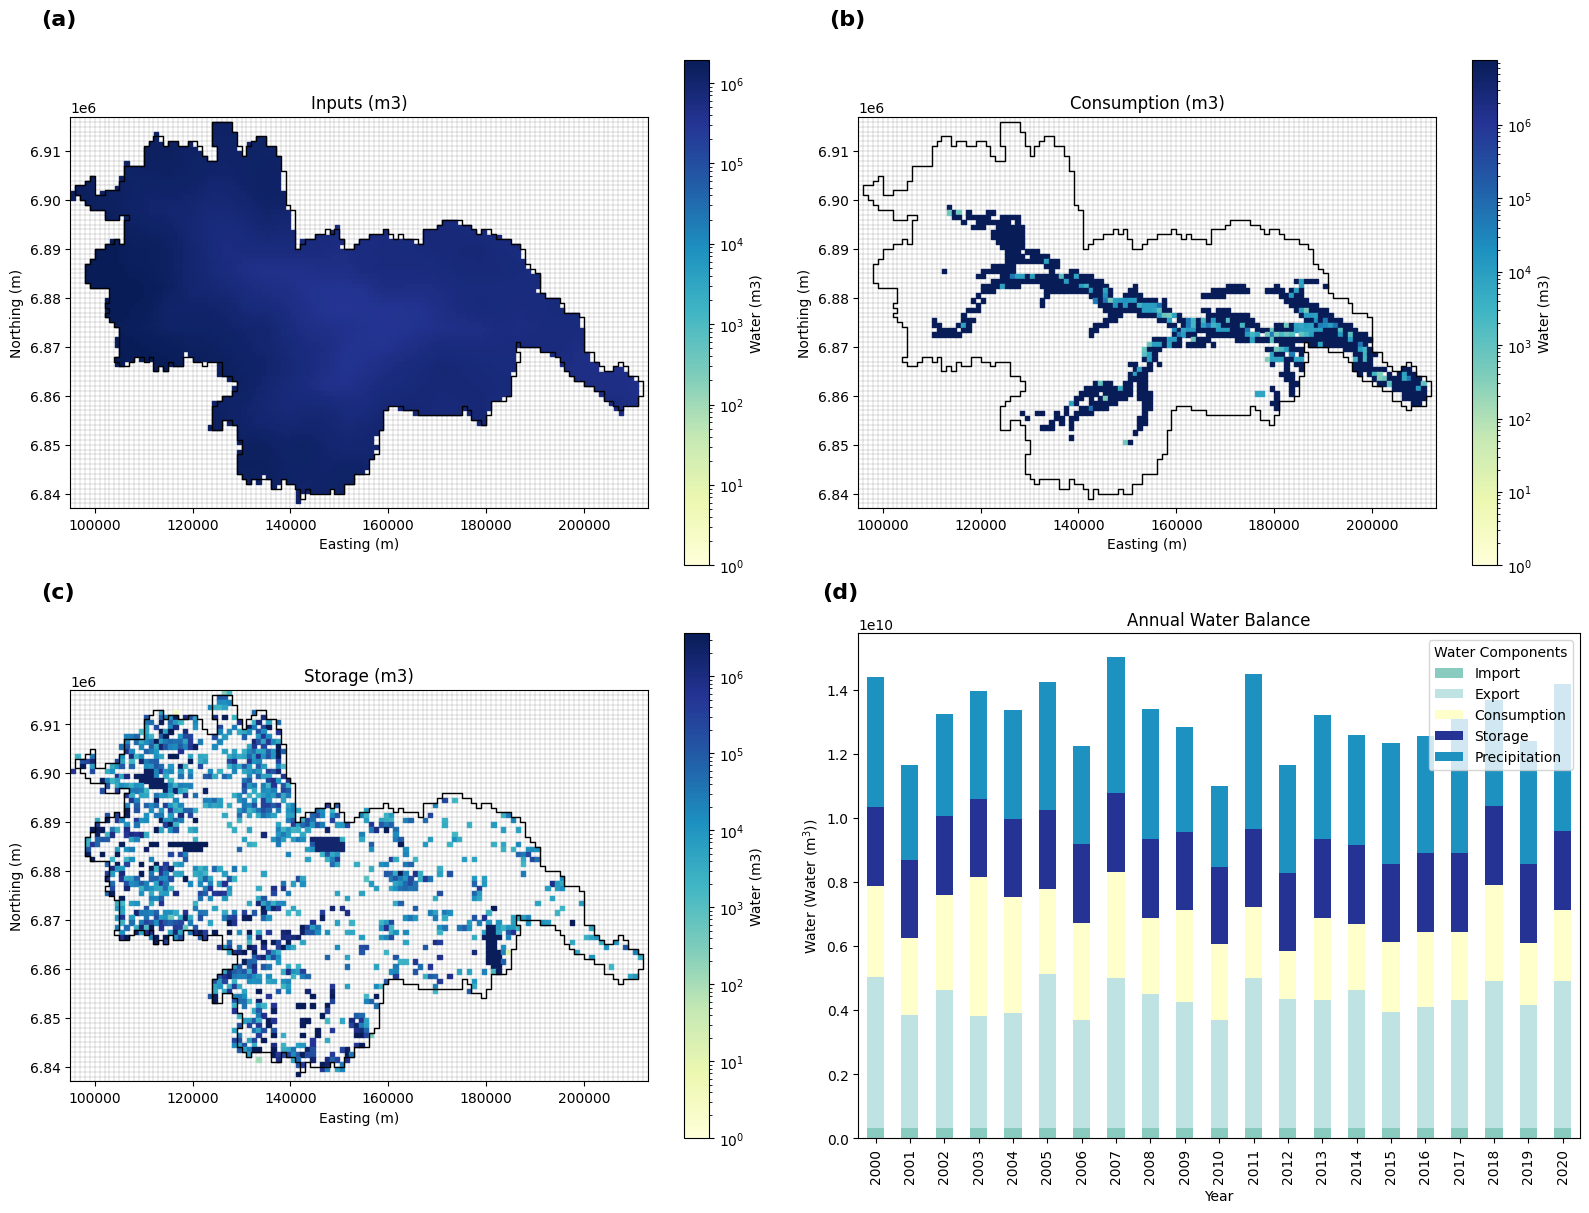

In [28]:
### Final Plot
# Input file paths
grid_consumption_file = "./Outputs/Water/total_consumption_per_cell.csv"
grid_production_file = "./Input_Data/Meteo/Annual_precip_per_cell.csv"
grid_storage_file = "./Outputs/Water/Total_Storage_per_cell.csv"
boundary_shapefile = "./Input_Data/maps/mask/Otta_mask.shp"
annual_balance_file = "./Outputs/Water/Annual_Water_Balance.csv"

# Define consistent column-color mapping
column_color_map = {
    'Consumption': '#FFFFCC',   # Light Yellow
    'Import': '#89cbbf',        # Light Teal
    'Export': '#BFE3E3',        # Aqua Blue
    'Precipitation': '#1D91C0', # Medium Blue
    'Storage': '#253494'        # Dark Blue
}

# Reorder colors for the bar plot
stacked_colors = [column_color_map[col] for col in annual_balance.columns if col != 'Year']

# Plot settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
titles = ["Inputs (m3)", "Consumption (m3)", "Storage (m3)", "Annual Balance"]
data_grids = [
    (production_grid, "Mean_Annual"),
    (consumption_grid, "Total_Mean_Consumption"),
    (storage_grid, "Total_Storage")
]
panel_labels = ['(a)', '(b)', '(c)', '(d)']


# Plot production, consumption, and storage maps with grid overlay
for i, (ax, (data_grid, col)) in enumerate(zip(axes.flat[:3], data_grids)):
    # Adjust color scaling with LogNorm for better visibility
    if data_grid[col].max() > 0:
        norm = LogNorm(vmin=max(data_grid[col].min(), 1), vmax=data_grid[col].quantile(0.99))
    else:
        norm = Normalize(vmin=0, vmax=1)
    # Add grid overlay
    add_grid_overlay(ax, data_grid, cell_size)
    # Plot grid data
    sc = ax.scatter(
        data_grid["X"], data_grid["Y"],
        c=data_grid[col],
        cmap='YlGnBu',  # Consistent color map for maps
        s=10,
        marker='s',
        norm=norm
    )
    # Plot formatting
    ax.set_title(titles[i])
    ax.set_xlim(extent[0], extent[2])
    ax.set_ylim(extent[1], extent[3])
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.text(
        -0.05, 1.275, panel_labels[i],
        transform=ax.transAxes, fontsize=16, fontweight='bold',
        va='top', ha='left', color='black'
    )

    # Overlay boundary
    boundary.plot(ax=ax, edgecolor="black", facecolor="none")
    fig.colorbar(sc, ax=ax, orientation="vertical", label="Water (m3)")
    

# Grid settings (extent and size)
cell_size = 1000  # Grid cell size
grid_color = 'gray'  # Grid line color
grid_linewidth = 0.10  # Grid line thickness

# Function to add grid overlay
def add_grid_overlay(ax, grid_cells, cell_size):
    for _, row in grid_cells.iterrows():
        rect = patches.Rectangle(
            (row["X"] - cell_size / 2, row["Y"] - cell_size / 2),  # Bottom-left corner
            cell_size, cell_size,  # Width and height
            linewidth=grid_linewidth, edgecolor=grid_color, facecolor='none'
        )
        ax.add_patch(rect)
    
    
# Plot annual balance (stacked bar plot)
ax = axes[1, 1]
annual_balance.set_index("Year").plot(
    kind="bar",
    stacked=True,
    ax=ax,
    title="Annual Water Balance",
    ylabel="Water (Water (m$^3$))",
    xlabel="Year",
    color=stacked_colors  # Apply consistent colors
)

# Add panel label and legend
ax.text(
    -0.05, 1.10, panel_labels[3],
    transform=ax.transAxes, fontsize=16, fontweight='bold',
    va='top', ha='left', color='black'
)
ax.legend(loc='upper right', title="Water Components")

plt.tight_layout()
plt.savefig("./Results/Water_plot.jpg", dpi=300, bbox_inches='tight')
plt.show()
